# Case 3. Patient Drug Review

*Diresh Shrestha*

*Nikita Zaitcev* 

*Eduard Trukhliaev*

Last edited: 19.03.2020

Neural Networks for Health Technology Applications

Helsinki Metropolia University of Applied Sciences

### The task is  to use the methods of text processing and to experiment with recurrent and/or
### convolutional (1D) neural networks to create a classifier for a collection of patient drug reviews 

In [1]:
%pylab inline
import time 
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation 
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

Populating the interactive namespace from numpy and matplotlib


# Data Preprocessing

In [2]:
# Change the default figure size
plt.rcParams['figure.figsize'] = [12, 5]

In [3]:
#Load our training and test set
train = pd.read_csv("drugsComTrain_raw.csv")
test = pd.read_csv("drugsComTest_raw.csv")

train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
#list of all the labels
list(train)

['uniqueID',
 'drugName',
 'condition',
 'review',
 'rating',
 'date',
 'usefulCount']

# 1st Experiment

For our first experiment, we tried one-hot encoding.

### Preparing our training data

In [5]:
%%time
# Tokenize the text
samples = train['review']
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(samples)

# Make one hot samples
data = tokenizer.texts_to_matrix(samples, mode='binary')

Wall time: 23 s


In [6]:
%%time
# Create three different classes
# label = 2 or positive, when rating > 6
# label = 1 or neutral, when rating = 5 or 6
# label = 0 or negative, when rating < 5
labels = train['rating'].values
for i in range(len(labels)):
    x = labels[i]
    if x > 6:
        labels[i] = 2
    elif x == 5 or x == 6:
        labels[i] = 1
    elif x < 5:
        labels[i] = 0


Wall time: 122 ms


### Preparing our testing data

In [7]:
%%time
# Tokenize the text
test_samples = test['review']
test_tokenizer = Tokenizer(num_words = 5000)
test_tokenizer.fit_on_texts(test_samples)

# Make one hot samples
test_data = test_tokenizer.texts_to_matrix(test_samples, mode='binary')

Wall time: 7.75 s


In [8]:
%%time
# Create three different classes
# label = 2 or positive, when rating > 6
# label = 1 or neutral, when rating = 5 or 6
# label = 0 or negative, when rating < 5
test_labels = test['rating'].values
for i in range(len(test_labels)):
    x = test_labels[i]
    if x > 6:
        test_labels[i] = 2
    elif x == 5 or x == 6:
        test_labels[i] = 1
    elif x < 5:
        test_labels[i] = 0


Wall time: 40.9 ms


In [9]:
%%time
# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size = 0.25, random_state = 69)

Wall time: 15.2 s


In [10]:
%%time
# Convert outputs to one-hot-coded categoricals
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

Wall time: 75.8 ms


# Model

We decided to try solve this task with regular Dense neural network and then we compare result with models,that was designed for this type of problems

In [11]:
# Create a simple sequential model
model = Sequential()
model.add(Dense(256, input_dim = 5000))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1280256   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 1,288,579
Trainable params: 1,288,579
Non-trainable params: 0
______________________________________________

## Training the model

In [12]:
%%time
history = model.fit(x_train, y_train_cat, 
                    epochs = 10, 
                    batch_size = 32,
                    verbose = 1,
                    validation_data = (x_val, y_val_cat))

Train on 120972 samples, validate on 40325 samples
Epoch 1/10
120972/120972 [==============================] - 20s 162us/sample - loss: 0.5426 - acc: 0.7935 - val_loss: 0.4876 - val_acc: 0.8163
Epoch 2/10
120972/120972 [==============================] - 17s 139us/sample - loss: 0.3505 - acc: 0.8726 - val_loss: 0.4405 - val_acc: 0.8495
Epoch 3/10
120972/120972 [==============================] - 17s 140us/sample - loss: 0.1501 - acc: 0.9485 - val_loss: 0.5116 - val_acc: 0.8599
Epoch 4/10
120972/120972 [==============================] - 17s 139us/sample - loss: 0.0548 - acc: 0.9821 - val_loss: 0.7083 - val_acc: 0.8600
Epoch 5/10
120972/120972 [==============================] - 17s 138us/sample - loss: 0.0293 - acc: 0.9905 - val_loss: 0.8112 - val_acc: 0.8553
Epoch 6/10
120972/120972 [==============================] - 17s 140us/sample - loss: 0.0219 - acc: 0.9928 - val_loss: 0.9114 - val_acc: 0.8640
Epoch 7/10
120972/120972 [==============================] - 16s 132us/sample - loss: 0.0140

## Plotting

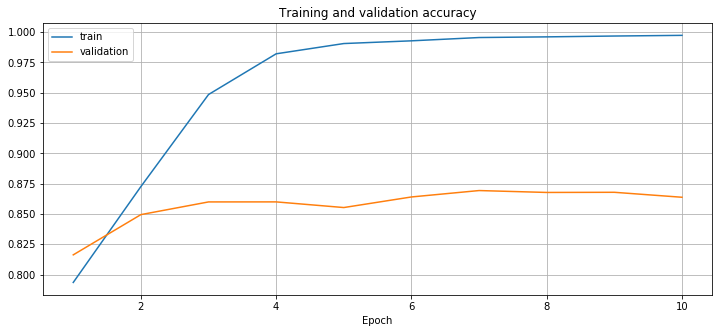

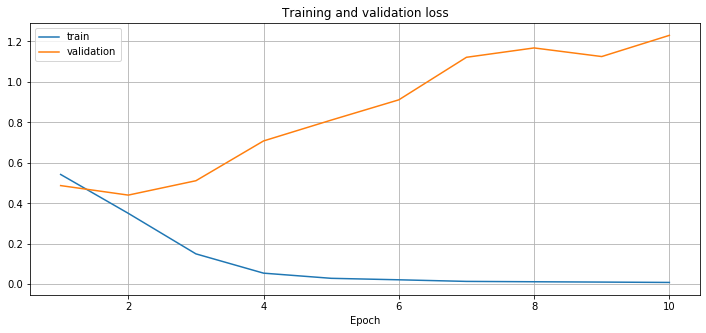

In [13]:
# Plot the accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
e = arange(len(acc)) + 1

plot(e, acc, label = 'train')
plot(e, val_acc, label = 'validation')
title('Training and validation accuracy')
xlabel('Epoch')
grid()
legend()

figure()

plot(e, loss, label = 'train')
plot(e, val_loss, label = 'validation')
title('Training and validation loss')
xlabel('Epoch')
grid()
legend()

show()

This model clearly overfits because the training accuracy is close to 100 while the validation accuracy levels out at 85%. The validation also increases while training loss is decreasing

## Metrics

In [14]:
# Find the predicted values for the test set
pred = argmax(model.predict(test_data), axis = 1)

In [15]:
# Calculate the classification report
cr = classification_report(test_labels, pred)
print(cr)

              precision    recall  f1-score   support

           0       0.33      0.30      0.31     13497
           1       0.12      0.08      0.10      4829
           2       0.69      0.75      0.72     35440

    accuracy                           0.58     53766
   macro avg       0.38      0.38      0.38     53766
weighted avg       0.55      0.58      0.56     53766



In [16]:
# Calculate the confusion matrix
cm = confusion_matrix(test_labels, pred).T
print(cm)

[[ 4017  1125  6953]
 [  866   384  1921]
 [ 8614  3320 26566]]


In [17]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(test_labels, pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(test_labels, pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.090
Cohen's kappa (quadratic) = 0.109


# 2nd Experiment

For our next experiment, we tried word embeddings. Also we change our model to 1-D Conv NN

## Data Preprocessing

### Preparing training data 

In [18]:
%%time

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(samples)


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 51429 unique tokens.
Wall time: 9.14 s


In [19]:
data1 = pad_sequences(sequences, maxlen=200)

In [20]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor: ', data1.shape)
print('Shape of label tensor: ', labels.shape)

Shape of data tensor:  (161297, 200)
Shape of label tensor:  (161297, 3)


### Preparing testing data

In [21]:
test_sequences = test_tokenizer.texts_to_sequences(test_samples)

In [22]:
test_data1 = pad_sequences(test_sequences, maxlen=200)
test_labels1 = to_categorical(np.asarray(test_labels))

In [23]:
VALIDATION_SPLIT = 0.25

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data1 = data1[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data1.shape[0])

x_train1 = data1[:-nb_validation_samples]
y_train1 = labels[:-nb_validation_samples]
x_val1 = data1[-nb_validation_samples:]
y_val1 = labels[-nb_validation_samples:]

## Model

In [24]:
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant

In [25]:
embedding_layer = Embedding(5000,
                            100,
                            input_length=200,
                            trainable=True)

sequence_input = Input(shape=(200,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

#A simple 1D ConvNet
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

model1 = Model(sequence_input, preds)
model1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 128)          38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 66, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 128)           49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19, 128)           49280 

### Training

In [26]:
%%time
history1 = model1.fit(x_train1, y_train1,
          batch_size=128,
          epochs=10,
          validation_data=(x_val1, y_val1))

Train on 120973 samples, validate on 40324 samples
Epoch 1/10
120973/120973 [==============================] - 21s 170us/sample - loss: 0.6333 - acc: 0.7539 - val_loss: 0.5429 - val_acc: 0.7994
Epoch 2/10
120973/120973 [==============================] - 17s 144us/sample - loss: 0.5150 - acc: 0.8069 - val_loss: 0.5081 - val_acc: 0.8144
Epoch 3/10
120973/120973 [==============================] - 18s 150us/sample - loss: 0.4527 - acc: 0.8287 - val_loss: 0.4946 - val_acc: 0.8181
Epoch 4/10
120973/120973 [==============================] - 18s 149us/sample - loss: 0.3926 - acc: 0.8507 - val_loss: 0.6058 - val_acc: 0.8041
Epoch 5/10
120973/120973 [==============================] - 18s 153us/sample - loss: 0.3356 - acc: 0.8733 - val_loss: 0.4947 - val_acc: 0.8296
Epoch 6/10
120973/120973 [==============================] - 19s 157us/sample - loss: 0.2796 - acc: 0.8961 - val_loss: 0.5137 - val_acc: 0.8335
Epoch 7/10
120973/120973 [==============================] - 17s 144us/sample - loss: 0.2311

### Plotting

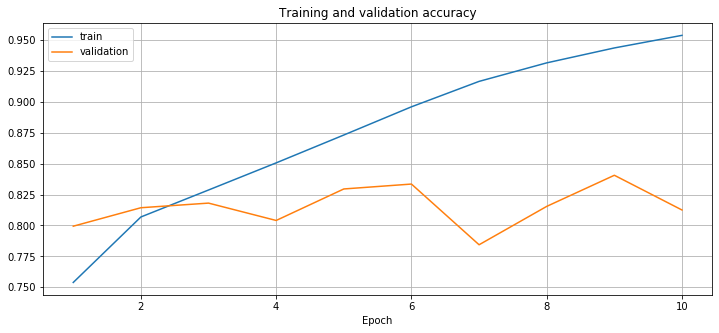

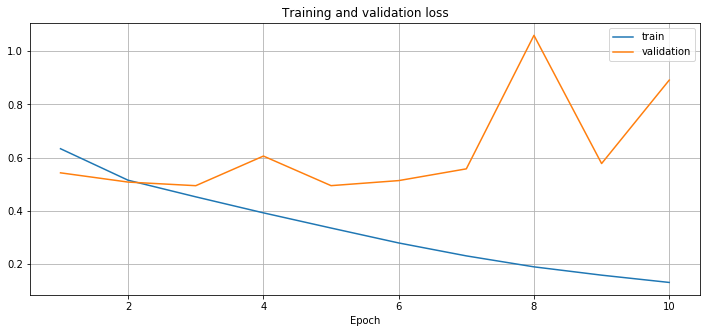

In [27]:
# Plot the accuracy and loss
acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
e1 = arange(len(acc1)) + 1

plot(e1, acc1, label = 'train')
plot(e1, val_acc1, label = 'validation')
title('Training and validation accuracy')
xlabel('Epoch')
grid()
legend()

figure()

plot(e1, loss1, label = 'train')
plot(e1, val_loss1, label = 'validation')
title('Training and validation loss')
xlabel('Epoch')
grid()
legend()

show()

### Metrics

In [28]:
# Find the predicted values for the test set
y_pred = argmax(model1.predict(test_data1), axis = 1)
y_true = argmax(test_labels1, axis = 1)

# Calculate the classification report
cr1 = classification_report(y_true, y_pred)
print(cr1)

              precision    recall  f1-score   support

           0       0.39      0.08      0.13     13497
           1       0.12      0.14      0.13      4829
           2       0.68      0.87      0.76     35440

    accuracy                           0.60     53766
   macro avg       0.40      0.36      0.34     53766
weighted avg       0.56      0.60      0.55     53766



In [29]:
# Calculate the confusion matrix
cm1 = confusion_matrix(y_true, y_pred).T
print(cm1)

[[ 1030   190  1403]
 [ 1726   671  3211]
 [10741  3968 30826]]


In [30]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k3 = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k3:.3f}")
k4 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k4:.3f}")

Cohen's kappa (linear)    = 0.060
Cohen's kappa (quadratic) = 0.071


# 3rd Experiment

For our third experiment, we tried a pretrained word embedding vector GloVe. We used Chollet's book as reference for this part.
Also with 1-D Conv

In [31]:
import os

#glove_dir = "/glove.6B"

embeddings_index = {}
f = open( 'glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [32]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [33]:

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant

embedding_layer1 = Embedding(len(word_index) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=200,
                            trainable=False)

In [34]:
sequence_input = Input(shape=(200,), dtype='int32')
embedded_sequences = embedding_layer1(sequence_input)

#A simple 1D ConvNet
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

model2 = Model(sequence_input, preds)
model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          5143000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 198, 128)          38528     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 66, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 64, 128)           49280     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 19, 128)           4928

In [35]:
history2 = model2.fit(x_train1, y_train1, validation_data=(x_val1, y_val1),
          epochs=10, batch_size=128)

Train on 120973 samples, validate on 40324 samples
Epoch 1/10
120973/120973 [==============================] - 12s 100us/sample - loss: 0.7153 - acc: 0.7136 - val_loss: 0.6349 - val_acc: 0.7567
Epoch 2/10
120973/120973 [==============================] - 11s 94us/sample - loss: 0.5962 - acc: 0.7693 - val_loss: 0.6218 - val_acc: 0.7584
Epoch 3/10
120973/120973 [==============================] - 11s 95us/sample - loss: 0.5389 - acc: 0.7929 - val_loss: 0.5909 - val_acc: 0.7782
Epoch 4/10
120973/120973 [==============================] - 11s 95us/sample - loss: 0.4986 - acc: 0.8089 - val_loss: 0.6173 - val_acc: 0.7536
Epoch 5/10
120973/120973 [==============================] - 11s 94us/sample - loss: 0.4615 - acc: 0.8232 - val_loss: 0.5296 - val_acc: 0.7962
Epoch 6/10
120973/120973 [==============================] - 11s 93us/sample - loss: 0.4296 - acc: 0.8353 - val_loss: 0.5407 - val_acc: 0.8057
Epoch 7/10
120973/120973 [==============================] - 11s 95us/sample - loss: 0.4018 - acc

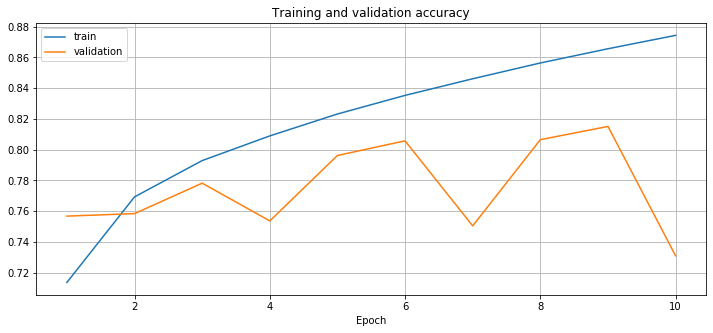

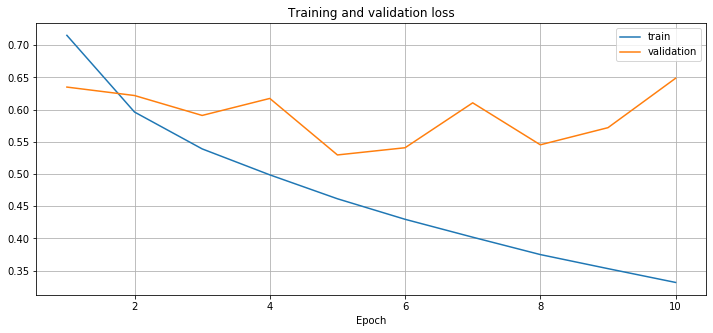

In [36]:
# Plot the accuracy and loss
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
e2 = arange(len(acc2)) + 1

plot(e2, acc2, label = 'train')
plot(e2, val_acc2, label = 'validation')
title('Training and validation accuracy')
xlabel('Epoch')
grid()
legend()

figure()

plot(e2, loss2, label = 'train')
plot(e2, val_loss2, label = 'validation')
title('Training and validation loss')
xlabel('Epoch')
grid()
legend()

show()

In [37]:
# Find the predicted values for the test set
y_pred1 = argmax(model2.predict(test_data1), axis = 1)
y_true1 = argmax(test_labels1, axis = 1)

# Calculate the classification report
cr2 = classification_report(y_true1, y_pred1)
print(cr2)

              precision    recall  f1-score   support

           0       0.34      0.27      0.30     13497
           1       0.11      0.40      0.17      4829
           2       0.71      0.51      0.60     35440

    accuracy                           0.44     53766
   macro avg       0.39      0.39      0.36     53766
weighted avg       0.57      0.44      0.48     53766



In [38]:
# Calculate the confusion matrix
cm2 = confusion_matrix(y_true1, y_pred1).T
print(cm2)

[[ 3603   924  6027]
 [ 4565  1922 11193]
 [ 5329  1983 18220]]


In [39]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k5 = cohen_kappa_score(y_true1, y_pred1)
print(f"Cohen's kappa (linear)    = {k5:.3f}")
k6 = cohen_kappa_score(y_true1, y_pred1, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k6:.3f}")

Cohen's kappa (linear)    = 0.082
Cohen's kappa (quadratic) = 0.120


# 4th Experiment

In the 4th experiment, we tried a simple Recurrent Neural network

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN
from tensorflow.keras.layers import Dense

## Model

In [41]:
model3 = Sequential()
model3.add(Embedding(5000, 32))
model3.add(SimpleRNN(32))
model3.add(Dense(3, activation='softmax'))

model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model3.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          160000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 99        
Total params: 162,179
Trainable params: 162,179
Non-trainable params: 0
_________________________________________________________________


### Training

In [42]:
%%time
history3 = model3.fit(x_train1, y_train1,
          batch_size=128,
          epochs=10,
          validation_data=(x_val1, y_val1))

Train on 120973 samples, validate on 40324 samples
Epoch 1/10
120973/120973 [==============================] - 82s 675us/sample - loss: 0.4054 - acc: 0.8260 - val_loss: 0.3812 - val_acc: 0.8352
Epoch 2/10
120973/120973 [==============================] - 80s 661us/sample - loss: 0.3383 - acc: 0.8627 - val_loss: 0.3578 - val_acc: 0.8543
Epoch 3/10
120973/120973 [==============================] - 81s 671us/sample - loss: 0.3195 - acc: 0.8707 - val_loss: 0.3395 - val_acc: 0.8625
Epoch 4/10
120973/120973 [==============================] - 82s 674us/sample - loss: 0.2999 - acc: 0.8788 - val_loss: 0.3745 - val_acc: 0.8544
Epoch 5/10
120973/120973 [==============================] - 79s 657us/sample - loss: 0.2811 - acc: 0.8870 - val_loss: 0.3741 - val_acc: 0.8459
Epoch 6/10
120973/120973 [==============================] - 75s 619us/sample - loss: 0.2640 - acc: 0.8949 - val_loss: 0.3648 - val_acc: 0.8477
Epoch 7/10
120973/120973 [==============================] - 79s 656us/sample - loss: 0.2486

### Plotting

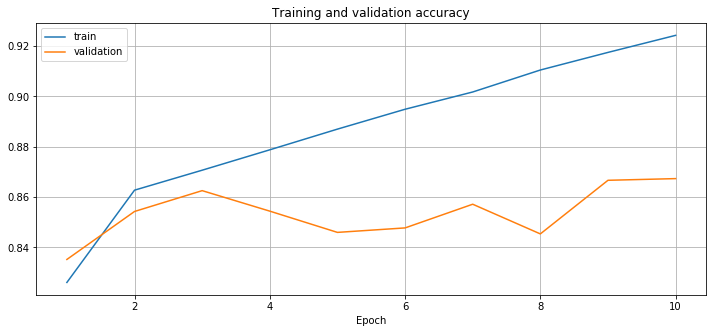

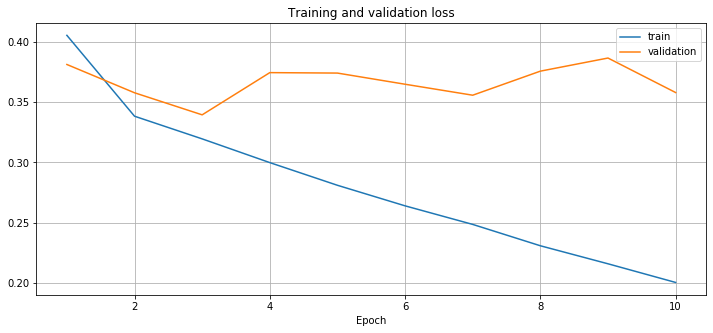

In [43]:
# Plot the accuracy and loss
acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
e3 = arange(len(acc3)) + 1

plot(e3, acc3, label = 'train')
plot(e3, val_acc3, label = 'validation')
title('Training and validation accuracy')
xlabel('Epoch')
grid()
legend()

figure()

plot(e3, loss3, label = 'train')
plot(e3, val_loss3, label = 'validation')
title('Training and validation loss')
xlabel('Epoch')
grid()
legend()

show()

In [44]:
# Find the predicted values for the test set
y_pred2 = argmax(model3.predict(test_data1), axis = 1)
y_true2 = argmax(test_labels1, axis = 1)

# Calculate the classification report
cr3 = classification_report(y_true2, y_pred2)
print(cr3)

              precision    recall  f1-score   support

           0       0.34      0.26      0.29     13497
           1       0.11      0.11      0.11      4829
           2       0.69      0.76      0.72     35440

    accuracy                           0.57     53766
   macro avg       0.38      0.37      0.37     53766
weighted avg       0.55      0.57      0.56     53766



In [45]:
# Calculate the confusion matrix
cm3 = confusion_matrix(y_true2, y_pred2).T
print(cm3)

[[ 3457   976  5713]
 [ 1499   529  2892]
 [ 8541  3324 26835]]


In [46]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k7 = cohen_kappa_score(y_true2, y_pred2)
print(f"Cohen's kappa (linear)    = {k7:.3f}")
k8 = cohen_kappa_score(y_true2, y_pred2, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k8:.3f}")

Cohen's kappa (linear)    = 0.090
Cohen's kappa (quadratic) = 0.071


### Conclusion

The last model using the RNN has the highest Kappa value on the test set of 9.19. Whereas the 2nd model using word embeddings has the highest accuracy on the test set with 60%. Compared to the original Grässer et al. article, they have an accuracy of 92.25 and Kappa of 83.99 so compared to them, ours performs very poorly.
